In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve,train_test_split,cross_validate, ShuffleSplit,GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,average_precision_score,mean_absolute_error,r2_score,confusion_matrix,classification_report
import seaborn as sns
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.svm import LinearSVC
import textwrap
from sklearn.decomposition import NMF,PCA
from itertools import product

In [37]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [38]:
#Organizo el archivo .json para descargar todo
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [39]:
#Se descarga el nuevo set de datos
!kaggle datasets download -d rosapuertacampo/database

  0% 0.00/2.38M [00:00<?, ?B/s]
100% 2.38M/2.38M [00:00<00:00, 143MB/s]


In [40]:
#Se descomprime
!unzip /content/database.zip

Archive:  /content/database.zip
  inflating: DB.csv                  


In [41]:
dataset=pd.read_csv('DB.csv')

In [42]:
dataset

,total_cases,new_cases,total_deaths,new_deaths,new_deaths_smoothed,new_tests_smoothed,new_vaccinations_smoothed,population,continent,location,tests_units,year,month,day,weekday
0,5.0,5.0,57700.0,171.0,172.000,61226.0,539550.0,39835428.0,1,0,2,2020,2,24,0
1,5.0,0.0,57700.0,171.0,172.000,61226.0,539550.0,39835428.0,1,0,2,2020,2,25,1
2,5.0,0.0,57700.0,171.0,172.000,61226.0,539550.0,39835428.0,1,0,2,2020,2,26,2
3,5.0,0.0,57700.0,171.0,172.000,61226.0,539550.0,39835428.0,1,0,2,2020,2,27,3
4,5.0,0.0,57700.0,171.0,172.000,61226.0,539550.0,39835428.0,1,0,2,2020,2,28,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163128,236871.0,491.0,5395.0,0.0,1.000,4063.0,9291.0,15092171.0,0,227,2,2022,3,1,1
163129,237503.0,632.0,5396.0,1.0,1.143,3827.0,9061.0,15092171.0,0,227,2,2022,3,2,2
163130,237503.0,0.0,5396.0,0.0,0.857,3940.0,8903.0,15092171.0,0,227,2,2022,3,3,3
163131,238739.0,1236.0,5397.0,1.0,0.714,4053.0,8603.0,15092171.0,0,227,2,2022,3,4,4


# Metricas

In [ ]:
x=dataset.drop(["new_cases"],axis=1)
y=dataset["new_cases"].values

In [ ]:
def train_test_evaluate(model_name, model, X_train, y_train, X_test, y_test):

    y_pred= model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred,squared=False)
    r2 = r2_score(y_test, y_pred)
    y_test_mean= y_test.mean()
    mae_ratio= mae/y_test_mean
    rmse_ratio= rmse/y_test_mean

    result_df = pd.DataFrame(
        data=[[model_name, mae, mse, rmse, r2, mae_ratio, rmse_ratio]],
        columns=["Model", 'MAE', 'MSE', 'RMSE', 'R2 Score', "MAE Ratio", "RMSE Ratio"])
    return result_df

In [ ]:
def report_cv_score(z):
    lr_ts_score = z['test_score']*(-1)
    lr_tr_score = z['train_score']*(-1)
    lin_rmse_ts = np.sqrt(lr_ts_score)
    lin_rmse_tr = np.sqrt(lr_tr_score)
    print("RMSE Test: ", "{:.5f}".format(np.mean(lin_rmse_ts)), "(±", "{:.8f}".format(np.std(lin_rmse_ts)),")")
    print("RMSE Train: ", "{:.5f}".format(np.mean(lin_rmse_tr)), "(±", "{:.8f}".format(np.std(lin_rmse_tr)),")")

In [ ]:
test_size = 0.3
val_size  = test_size/(1-test_size) # Elementos de validación


print (x.shape, y.shape)
print ("test size %.2f"%test_size)
print ("val size is %.2f (relative to %.2f) "%(val_size, 1-test_size))

Xtv, Xts, ytv, yts = train_test_split(x, y, test_size=test_size)
scaler=StandardScaler()
Xtv=scaler.fit_transform(Xtv)
Xts=scaler.fit_transform(Xts)
print (Xtv.shape, Xts.shape)

(163133, 14) (163133,)
test size 0.30
val size is 0.43 (relative to 0.70) 
(114193, 14) (48940, 14)


# Random Forest Regressor

In [ ]:
estimator = RandomForestRegressor(n_estimators = 3,max_depth = 4)

In [ ]:
print("--------------------")
z = cross_validate(estimator, Xtv, ytv, return_train_score=True, return_estimator=False,
                   scoring="neg_mean_squared_error", cv=ShuffleSplit(n_splits=10, test_size=val_size))
report_cv_score(z)
estimator.fit(Xtv, ytv)
result_df= train_test_evaluate("RandomForestRegressor", estimator, Xtv, ytv, Xts, yts)
result_df

--------------------
RMSE Test:  31315.47500 (± 2236.94892020 )
RMSE Train:  27998.81903 (± 1123.09450975 )


,Model,MAE,MSE,RMSE,R2 Score,MAE Ratio,RMSE Ratio
0,RandomForestRegressor,5758.672833,1.139008e+09,33749.196554,0.847414,0.4773,2.79726


In [ ]:
#Esta celda toma un tiempo considerable en completarse
parametros = {
    "n_estimators": list(range(20, 61, 20)),
    "max_depth": list(range(11, 20, 2)),
    "min_samples_leaf": list(range(1, 3)),
    "random_state": [23]
}

forest_reg = GridSearchCV(estimator = estimator,
                        param_grid = parametros,
                        cv = ShuffleSplit(n_splits= 5, test_size=val_size),
                        scoring = 'neg_mean_squared_error',
                        verbose = 2,
                        n_jobs=-1)
forest_reg.fit(Xtv, ytv)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=0.4285714285714286,
       train_size=None),
             estimator=RandomForestRegressor(max_depth=4, n_estimators=3),
             n_jobs=-1,
             param_grid={'max_depth': [11, 13, 15, 17, 19],
                         'min_samples_leaf': [1, 2],
                         'n_estimators': [20, 40, 60], 'random_state': [23]},
             scoring='neg_mean_squared_error', verbose=2)

In [ ]:
print("Mejor estimador Random Forest: ",forest_reg.best_estimator_)
print("Mejores parámetros para el estimador Random Forest: ", forest_reg.best_params_)

Mejor estimador Random Forest:  RandomForestRegressor(max_depth=17, n_estimators=60, random_state=23)
Mejores parámetros para el estimador Random Forest:  {'max_depth': 17, 'min_samples_leaf': 1, 'n_estimators': 60, 'random_state': 23}


In [ ]:
Rdm_forest = RandomForestRegressor(n_estimators =forest_reg.best_params_["n_estimators"]
                                   ,max_depth = forest_reg.best_params_["max_depth"],
                                   min_samples_leaf=forest_reg.best_params_["min_samples_leaf"],
                                   random_state=forest_reg.best_params_["random_state"])
Rdm_forest.fit(Xtv, ytv)

RandomForestRegressor(max_depth=17, n_estimators=60, random_state=23)

In [ ]:
print('RMSE del Random Forest en entrenamiento: ',"{:.5f}".format(mean_squared_error(ytv , Rdm_forest.predict(Xtv),squared=False)))
print('RMSE del Random Forest seleccionado: ',"{:.5f}".format(mean_squared_error(yts , Rdm_forest.predict(Xts))))

RMSE del Random Forest en entrenamiento:  5376.41572
RMSE del Random Forest seleccionado:  239827233.32266


In [ ]:
df1=train_test_evaluate("Mejor Random Forest", Rdm_forest, Xtv, ytv, Xts, yts)
result_df=pd.concat([result_df,df1],ignore_index=True)

In [ ]:
def lc_plot(estimator,X,y):
    train_sizes, train_scores, valid_scores = learning_curve(estimator, X, y, train_sizes= [0.3, 0.5,0.7,0.9],
                 scoring ='neg_root_mean_squared_error', cv = ShuffleSplit(n_splits=10, test_size=val_size))

    train_scores = np.abs(train_scores)
    valid_scores = np.abs(valid_scores)

    train_mean = np.mean(train_scores, axis=1)

    valid_mean = np.mean(valid_scores, axis=1)

    plt.subplots(1, figsize=(5,5))
    plt.plot(train_sizes, train_mean, '--', color="r",  label="Training score")
    plt.plot(train_sizes, valid_mean, color="g", label="Cross-validation score")



    plt.grid()
    plt.title("Learning Curve")
    plt.xlabel("Training Set Size"), plt.ylabel("RMSE"), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()
    return plt

In [ ]:
test_size = 0.3
val_size  = test_size/(1-test_size) # Elementos de validación

print (x.shape, y.shape)
print ("test size %.2f"%test_size)
print ("val size is %.2f (relative to %.2f) "%(val_size, 1-test_size))

#Xtv, ytv son los datos que se usan para entrenar el modelo
#Xts, yts son los datos que se usan para probar el modelo (solo se usan para el testeo final de los modelos que se seleccionen)
Xtv, Xts, ytv, yts = train_test_split(x, y, test_size=test_size)
print (Xtv.shape, Xts.shape)

(163133, 14) (163133,)
test size 0.30
val size is 0.43 (relative to 0.70) 
(114193, 14) (48940, 14)


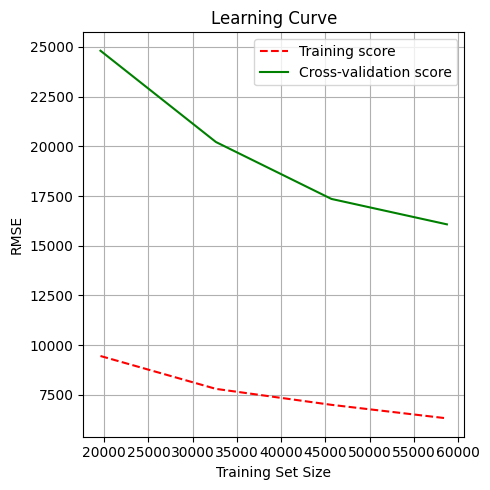

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

In [ ]:
lc_plot(Rdm_forest,Xtv,ytv)

# PCA + random forest

In [ ]:
components = [1,3,5,7,9]
test_size = 0.3
val_size  = test_size/(1-test_size)
perf_pca = []
Rdm_forest = RandomForestRegressor(n_estimators =forest_reg.best_params_["n_estimators"]
                                   ,max_depth = forest_reg.best_params_["max_depth"],
                                   min_samples_leaf=forest_reg.best_params_["min_samples_leaf"]
                                   ,random_state=forest_reg.best_params_["random_state"])
for i in components:
    pca = PCA(n_components = i)
    X_t = pca.fit_transform(x)
    Xtv, Xts, ytv, yts = train_test_split(X_t, y, test_size=test_size)
    print (Xtv.shape, Xts.shape)
    Rdm_forest.fit(Xtv, ytv)
    perf_pca.append(mean_squared_error(yts , Rdm_forest.predict(Xts),squared=False))
    print('RMSE del modelo con ', i ,'elementos: ',"{:.5f}".format(mean_squared_error(yts , Rdm_forest.predict(Xts),squared=False)))
    print('------------')

print('Mejor RMSE: ',"{:.5f}".format(np.min(perf_pca)),'  ; obtenido con ',components[np.argmin(perf_pca)])

(114193, 1) (48940, 1)
RMSE del modelo con  1 elementos:  18302.53010
------------
(114193, 3) (48940, 3)
RMSE del modelo con  3 elementos:  19018.12548
------------
(114193, 5) (48940, 5)
RMSE del modelo con  5 elementos:  19441.67218
------------
(114193, 7) (48940, 7)
RMSE del modelo con  7 elementos:  12472.02219
------------
(114193, 9) (48940, 9)
RMSE del modelo con  9 elementos:  14717.58799
------------
Mejor RMSE:  12472.02219   ; obtenido con  7


In [ ]:
#MEJOR PCA
pca = PCA(n_components = components[np.argmin(perf_pca)])
X_t1 = pca.fit_transform(x)
Xtv, Xts, ytv, yts = train_test_split(X_t1, y, test_size=test_size)
print (Xtv.shape, Xts.shape)

(114193, 7) (48940, 7)


In [ ]:
Rdm_forest.fit(Xtv,ytv)

RandomForestRegressor(max_depth=17, n_estimators=60, random_state=23)

In [ ]:
#Desempeño del modelo Random Forest seleccionado
print('RMSE Random Forest en entrenamiento: ',"{:.5f}".format(mean_squared_error(ytv , Rdm_forest.predict(Xtv),squared=False)))
print('RMSE del Random Forest seleccionado: ',"{:.5f}".format(mean_squared_error(yts , Rdm_forest.predict(Xts), squared=False)))

RMSE Random Forest en entrenamiento:  5288.17834
RMSE del Random Forest seleccionado:  14335.54637


In [ ]:
#Nota: Correr esta celda toma un tiempo considerable
forest_reg_pca = GridSearchCV(estimator = estimator,
                        param_grid = parametros,
                        cv = ShuffleSplit(n_splits= 5, test_size=val_size),
                        scoring = 'neg_mean_squared_error',
                        verbose = 2,
                        n_jobs = -1)
forest_reg_pca.fit(Xtv, ytv)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=0.4285714285714286,
       train_size=None),
             estimator=RandomForestRegressor(max_depth=4, n_estimators=3),
             n_jobs=-1,
             param_grid={'max_depth': [11, 13, 15, 17, 19],
                         'min_samples_leaf': [1, 2],
                         'n_estimators': [20, 40, 60], 'random_state': [23]},
             scoring='neg_mean_squared_error', verbose=2)

In [ ]:
print("Mejor estimador Random Forest: ",forest_reg_pca.best_estimator_)
print("Mejores parámetros para el estimador Random Forest: ", forest_reg_pca.best_params_)

Mejor estimador Random Forest:  RandomForestRegressor(max_depth=19, n_estimators=60, random_state=23)
Mejores parámetros para el estimador Random Forest:  {'max_depth': 19, 'min_samples_leaf': 1, 'n_estimators': 60, 'random_state': 23}


In [ ]:
#Mejor random forest para el PCA obtenido
Rdm_forest = RandomForestRegressor(n_estimators =forest_reg_pca.best_params_["n_estimators"]
                                   ,max_depth = forest_reg_pca.best_params_["max_depth"],
                                   min_samples_leaf=forest_reg_pca.best_params_["min_samples_leaf"],
                                   random_state=forest_reg_pca.best_params_["random_state"])
Rdm_forest.fit(Xtv, ytv)

RandomForestRegressor(max_depth=19, n_estimators=60, random_state=23)

In [ ]:
test_size = 0.3
val_size  = test_size/(1-test_size) # Elementos de validación

print (x.shape, y.shape)
print ("test size %.2f"%test_size)
print ("val size is %.2f (relative to %.2f) "%(val_size, 1-test_size))

#Xtv, ytv son los datos que se usan para entrenar el modelo
#Xts, yts son los datos que se usan para probar el modelo (solo se usan para el testeo final de los modelos que se seleccionen)
Xtv, Xts, ytv, yts = train_test_split(x, y, test_size=test_size)
print (Xtv.shape, Xts.shape)

(163133, 14) (163133,)
test size 0.30
val size is 0.43 (relative to 0.70) 
(114193, 14) (48940, 14)


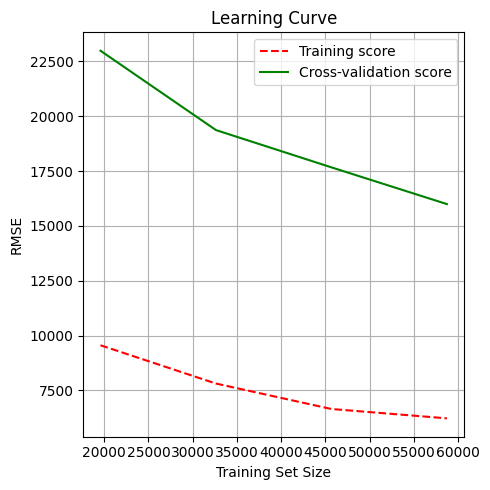

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

In [ ]:
lc_plot(Rdm_forest,Xtv,ytv)